In [1]:
import pandas as pd
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
import patsy
from patsy import dmatrix

sns.set_style('darkgrid')

# Use this in notebook to show plots
%matplotlib inline

import sklearn
from sklearn.datasets import load_boston # No usaremos este, sino el Iris
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.datasets import load_breast_cancer
import seaborn as sns
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import os
from sklearn.tree import export_graphviz
import six

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd


In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# League of Legends Data Analysis 

In this part of the project we take the necesarry time and resources to clean and analyze the dataset to the point where the dataset is tidy and every aspect of the dataset is understood (which considering my previous knowledge of the game it may not take that much time). 

Heres how the dataset looked at the beginning of the process. Originally, the dataset had the champion and summoner spells IDs instead of the name of the champion or spell. This may not seem as a big problem since we will not be concentrating on the champions for these projects, but this will definitely cause some problems if you dont know anything of the game and you just see a bunch of numbers with no apparent meaning. 

In [3]:
df = pd.read_csv('games.csv')
df.head()


,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


# Champion ID to Name 

### Champion Dictionary

In [4]:
jDict = pd.read_json('champion_info_2.json')
champInfo = pd.read_json((jDict['data']).to_json(), orient='index')
champInfo.set_index(['id'], inplace=True)
champInfo.tail()

,key,name,tags,title
id,,,,
154,Zac,Zac,"[Tank, Fighter]",the Secret Weapon
238,Zed,Zed,"[Assassin, Fighter]",the Master of Shadows
115,Ziggs,Ziggs,[Mage],the Hexplosives Expert
26,Zilean,Zilean,"[Support, Mage]",the Chronokeeper
143,Zyra,Zyra,"[Mage, Support]",Rise of the Thorns


### Spell Dictionary 

In [5]:
spellJson = pd.read_json('summoner_spell_info.json')
spellInfo = pd.read_json((spellJson['data']).to_json(),orient='index')
spellInfo.head()

,description,id,key,name,summonerLevel
1,Removes all disables (excluding suppression an...,1,SummonerBoost,Cleanse,6
11,Deals 390-1000 true damage (depending on champ...,11,SummonerSmite,Smite,10
12,"After channeling for 4.5 seconds, teleports yo...",12,SummonerTeleport,Teleport,6
13,Restores 50% of your champion's maximum Mana. ...,13,SummonerMana,Clarity,1
14,"Ignites target enemy champion, dealing 70-410 ...",14,SummonerDot,Ignite,10


In [6]:
champCols = ['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']
banCols = ['t1_ban1','t1_ban2','t1_ban3','t1_ban4','t1_ban5',
             't2_ban1','t2_ban2','t2_ban3','t2_ban4','t2_ban5',]
sumSpellsCols = ['t1_champ1_sum1','t1_champ1_sum2','t1_champ2_sum1','t1_champ2_sum2','t1_champ3_sum1','t1_champ3_sum2',
                 't1_champ4_sum1','t1_champ4_sum2','t1_champ5_sum1','t1_champ5_sum2','t2_champ1_sum1','t2_champ1_sum2',
                 't2_champ2_sum1','t2_champ2_sum2','t2_champ3_sum1','t2_champ3_sum2','t2_champ4_sum1','t2_champ4_sum2',
                 't2_champ5_sum1','t2_champ5_sum2']

In [7]:


def idToName(ID, dic):
    '''
    ID: champion ID as listed in original dataframe
    dic: champInfo from json, defined above

    used to convert ID's to champion names
    '''
    champ = dic['name'][ID]
    return champ  

In [8]:

for c in champCols:
    df[c] = df[c].apply(lambda x: idToName(x, champInfo))

for c in banCols:
    df[c] = df[c].apply(lambda x: idToName(x, champInfo)) 

for c in sumSpellsCols:
    df[c] = df[c].apply(lambda x: idToName(x, spellInfo))

    

As you can see now, both the columns of champions and summoner spells have been changed to its real names. 

In [9]:
df['t1_champ2_sum1'].unique()

array(['Exhaust', 'Teleport', 'Smite', 'Flash', 'Heal', 'Ignite',
       'Barrier', 'Ghost', 'Cleanse'], dtype=object)

In [10]:
df['t1_champ2id'].unique()

array(['Bard', 'Irelia', 'Kayn', 'Brand', 'Twitch', 'Teemo', 'Xayah',
       'Maokai', 'Master Yi', 'Lucian', 'Twisted Fate', 'Fizz', 'LeBlanc',
       'Ahri', 'Katarina', 'Janna', 'Ezreal', 'Lee Sin', 'Corki',
       'Dr. Mundo', 'Lulu', 'Kalista', 'Evelynn', 'Tryndamere', 'Viktor',
       "Cho'Gath", 'Yasuo', 'Miss Fortune', 'Leona', 'Akali', 'Tristana',
       'Thresh', 'Olaf', 'Sona', 'Braum', "Kog'Maw", 'Draven', 'Gragas',
       'Rakan', 'Ekko', 'Malzahar', 'Trundle', 'Blitzcrank', 'Zed',
       'Ashe', 'Jarvan IV', 'Kled', 'Rammus', 'Warwick', 'Kennen',
       'Elise', 'Nasus', 'Fiddlesticks', 'Taric', 'Shen', 'Nami', 'Kayle',
       'Soraka', 'Darius', 'Nidalee', 'Karma', 'Vi', 'Rumble', 'Varus',
       'Gnar', 'Syndra', 'Taliyah', 'Gangplank', 'Veigar', 'Heimerdinger',
       'Jinx', 'Vayne', 'Caitlyn', 'Xin Zhao', 'Aurelion Sol', 'Udyr',
       "Kha'Zix", 'Morgana', 'Lux', 'Renekton', 'Alistar', 'Quinn',
       'Sivir', 'Jhin', 'Rengar', 'Nocturne', 'Lissandra', 'Shyvana',
  

# Exploratory Analysis 

## NA Analysis

It would we really weird to find any kind of NA values that are really just noise. In these kind of MOBA games missing values often do have a meaning. Plus, the dataset we are using was downloaded using the Riot Games API using the Casipieia wrap so there are low chances of the dataset having NAs. But just for the fun of it, lets be sure.  

In [11]:
len(df) - df.count()

gameId                0
creationTime          0
gameDuration          0
seasonId              0
winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_champ1id           0
t1_champ1_sum1        0
t1_champ1_sum2        0
t1_champ2id           0
t1_champ2_sum1        0
t1_champ2_sum2        0
t1_champ3id           0
t1_champ3_sum1        0
t1_champ3_sum2        0
t1_champ4id           0
t1_champ4_sum1        0
t1_champ4_sum2        0
t1_champ5id           0
t1_champ5_sum1        0
t1_champ5_sum2        0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
                     ..
t1_ban1               0
t1_ban2               0
t1_ban3               0
t1_ban4               0
t1_ban5               0
t2_champ1id           0
t2_champ1_sum1        0
t2_champ1_sum2        0
t2_champ2id           0
t2_champ2_sum1        0
t2_champ2_sum2  

## Correlation Heat Map

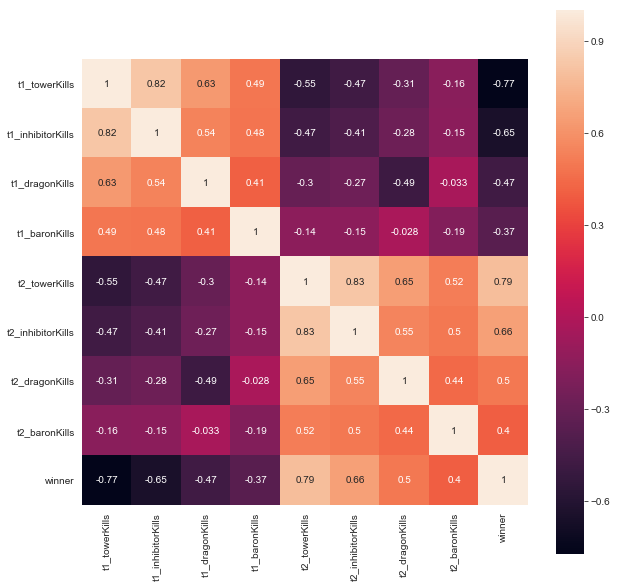

In [23]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df[['t1_towerKills','t1_inhibitorKills','t1_dragonKills','t1_baronKills',
                  't2_towerKills','t2_inhibitorKills','t2_dragonKills','t2_baronKills','winner']].corr(),annot=True,square=True)

In [24]:
data = df
sumPicks = pd.concat([df['t1_champ1id'],data['t1_champ2id'],data['t1_champ3id'],data['t1_champ4id'],data['t1_champ5id'],
                      data['t2_champ1id'],data['t2_champ2id'],data['t2_champ3id'],data['t2_champ4id'],data['t2_champ5id']],
                      ignore_index=True)
sortedPicks = sorted(sumPicks)
sumBans = pd.concat([data['t1_ban1'],data['t1_ban2'],data['t1_ban3'],data['t1_ban4'],data['t1_ban5'],
                     data['t2_ban1'],data['t2_ban2'],data['t2_ban3'],data['t2_ban4'],data['t2_ban5']],
                     ignore_index=True)
sortedBans = sorted(sumBans)

# Most Banned Champions and Most Common Picks 


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,30))
plt.xticks(rotation=90)
sns.countplot(y=sortedPicks, data=data, ax=ax1)
sns.countplot(y=sortedBans, data=data, ax=ax2)
ax1.set_title('Champion Picks')
ax2.set_title('Champion Bans')

# Team Priorities

League of Legends has a wide arrange of objectives you may want to fight for if you want to ensure victory. Defending towers, epic dragons, a Hydra-like monster called Baron Nashor, and the Rift Herald are just some of the factors that will determine the probabilities of your team destroying the enemy's nexus before they destroy yours. 

So knowing wich team was the first one to secure said objectives can give us an idea to how important these are to the result of the game. 

In [14]:
dataClean = data.replace([0,1,2],['neither','blue','red'])

dataClean.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,blue,red,blue,blue,blue,blue,...,5,neither,neither,blue,blue,Fiora,Vayne,Karma,Soraka,Caitlyn
1,3229566029,1497848803862,1851,9,blue,blue,blue,blue,neither,blue,...,red,neither,neither,neither,neither,Master Yi,Vayne,Zed,Caitlyn,Illaoi
2,3327363504,1504360103310,1493,9,blue,red,blue,blue,blue,red,...,red,neither,neither,blue,neither,Yasuo,Zed,Kha'Zix,Maokai,Evelynn
3,3326856598,1504348503996,1758,9,blue,blue,blue,blue,blue,blue,...,neither,neither,neither,neither,neither,Camille,Tristana,Kayn,Janna,Caitlyn
4,3330080762,1504554410899,2094,9,blue,red,blue,blue,blue,blue,...,3,neither,neither,blue,neither,Garen,Master Yi,Braum,Darius,Tristana


To speed up the analitic process I will change the 0 values to neither, 1 values to blue, and 2 values to red, so we can identify if the red or the blue team secured said objectives. Plus, it will be easier to see on the graphs which team had the early game edge. 

In [29]:
firsts = ['firstBlood','firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald']
firstTotals = dataClean[firsts].apply(pd.value_counts)
newIndex = ['blue','red','neither']
firstSort = firstTotals.reindex(index=newIndex)
firstSort

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
blue,26113,25861,23054,14758,24690,12948
red,24822,24416,22160,16474,24800,12363
neither,555,1213,6276,20258,2000,26179


Now, we will simply divide the data to have a better look at how it will be spreading on the graphs. 

### First Blood per Teams 

Text(0.5, 1.0, 'First Blood')

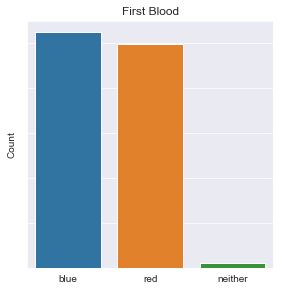

In [28]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,1)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[0]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Blood")

**First Tower Per Teams**

Text(0.5, 1.0, 'First Tower')

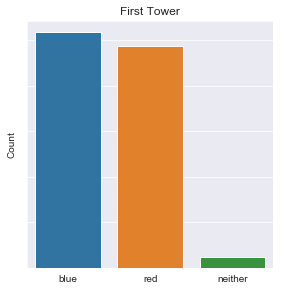

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,2)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[1]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Tower")

**First Inhibitor Per Teams**


Text(0.5, 1.0, 'First Inhibitor')

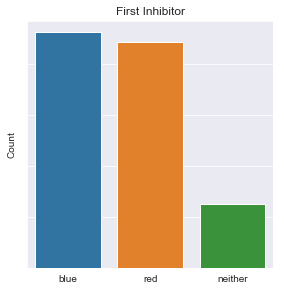

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,2)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[2]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Inhibitor")

**First Baron Per Teams**

Text(0.5, 1.0, 'First Baron')

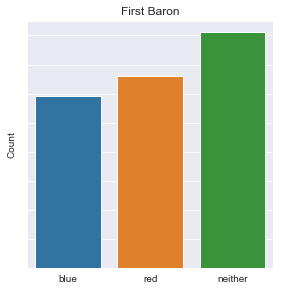

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,2)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[3]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Baron")

**First Dragon Per Teams**

Text(0.5, 1.0, 'First Dragon')

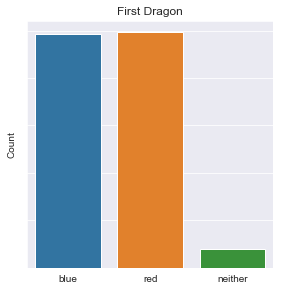

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,2)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[4]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Dragon")

**First Rift Herald Per Teams**

Text(0.5, 1.0, 'First Rift Herald')

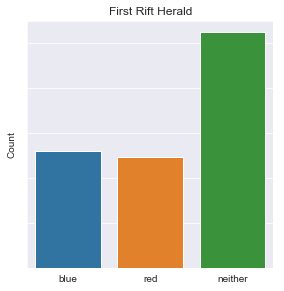

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,3,2)
sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[5]])
ax.set_ylabel('Count')
ax.yaxis.set_ticklabels([])
ax.set_title("First Rift Herald")

In [33]:
dataClean.to_csv("Clean_LeagueOfLegends.csv")
